# EcoBalance360: Balance de Carbono Municipal en Santander

**Modelo Predictivo de Desagregación Territorial de Gases de Efecto Invernadero (GEI)**

---

## Resumen Ejecutivo

Este notebook implementa un modelo de estimación de emisiones y captura de CO₂ equivalente para los 87 municipios del departamento de Santander, Colombia, utilizando datos abiertos del año 2019. La metodología sigue los lineamientos del Panel Intergubernamental de Expertos sobre Cambio Climático (IPCC 2006/2019) y estructura los cálculos en los cinco módulos oficiales del inventario nacional:

1. Energía
2. Procesos Industriales y Uso de Productos (IPPU)
3. Agricultura, Silvicultura y Otros Usos de la Tierra (AFOLU)
4. Uso del Suelo, Cambio de Uso del Suelo y Silvicultura (LULUCF)
5. Residuos

El resultado es un Índice de Equilibrio Climático (IEC) que clasifica cada municipio como emisor neto o sumidero de carbono, permitiendo priorizar acciones de mitigación y compensación climática.

**Autor:** Colectivo HAGAMOS  
**Fecha:** Noviembre 2025  
**Licencia:** MIT

## 1. Configuración del Entorno

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl plotly -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

RANDOM_STATE = 42

Mounted at /content/drive


## 2. Carga de Datos

In [4]:
# Dataset consolidado de 87 municipios de Santander (2019)
# Fuentes: DANE, ICA, SUI, EVA, Global Forest Watch, ANM, RUNT
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BasesDatosExcel/consolidado_final_definitivo_santander_2019.xlsx')

print(f'Municipios cargados: {df.shape[0]}')
print(f'Variables disponibles: {df.shape[1]}')

Municipios cargados: 87
Variables disponibles: 39


In [5]:
# Verificación de integridad
nulos = df.isnull().sum().sum()
print(f'Valores nulos totales: {nulos}')
print(f'Códigos de municipio únicos: {df["codMunicipio"].nunique()}')

Valores nulos totales: 0
Códigos de municipio únicos: 87


## 3. Metodología IPCC

### 3.1 Enfoque General

La estimación de emisiones sigue la ecuación fundamental del IPCC:

$$E = DA \times FE$$

Donde:
- $E$ = Emisiones (ton CO₂eq)
- $DA$ = Dato de Actividad (variable proxy medible)
- $FE$ = Factor de Emisión (ton CO₂eq / unidad de actividad)

### 3.2 Potencial de Calentamiento Global (GWP)

Para convertir diferentes GEI a CO₂ equivalente se utilizan los valores GWP-100 del IPCC AR5:

| Gas | GWP-100 |
|-----|--------:|
| CO₂ | 1 |
| CH₄ | 28 |
| N₂O | 265 |

In [7]:
# Potenciales de calentamiento global (IPCC AR5)
GWP = {
    'CO2': 1,
    'CH4': 28,
    'N2O': 265
}

## 4. Módulo 1: Energía

### 4.1 Consumo Eléctrico

El factor de emisión para electricidad en Colombia corresponde al factor de emisión de la red eléctrica nacional (UPME/FECOC):

$$E_{elec} = CE \times FE_{red}$$

Donde:
- $CE$ = Consumo eléctrico (kWh)
- $FE_{red}$ = 0.126 kg CO₂/kWh (factor Colombia 2019, fuente: UPME)

### 4.2 Transporte

Estimación basada en vehículos registrados, asumiendo recorrido promedio anual y consumo medio:

$$E_{trans} = V \times km_{anual} \times FE_{combustible}$$

Supuestos:
- Recorrido promedio: 15,000 km/año
- Rendimiento promedio: 40 km/galón
- Factor emisión gasolina: 2.31 kg CO₂/litro

In [8]:
# Factores de emisión - Módulo Energía
FE_ELECTRICIDAD = 0.126 / 1000  # ton CO2/kWh (Colombia 2019)
KM_ANUAL_PROMEDIO = 15000
RENDIMIENTO_KM_GALON = 40
LITROS_POR_GALON = 3.785
FE_GASOLINA = 2.31 / 1000  # ton CO2/litro

# Consumo eléctrico total por municipio (kWh)
df['consumoElectricoTotal'] = (
    df['consumoElectricoResidencial'] +
    df['consumoElectricoIndustrial'] +
    df['consumoElectricoComercial'] +
    df['consumoElectricoOficial'] +
    df['consumoElectricoOtros']
)

# Emisiones por electricidad
df['emisionesElectricidad'] = df['consumoElectricoTotal'] * FE_ELECTRICIDAD

# Emisiones por transporte vehicular
litros_consumidos = (df['cantidadVehiculosRegistrados'] * KM_ANUAL_PROMEDIO) / (RENDIMIENTO_KM_GALON * LITROS_POR_GALON) * LITROS_POR_GALON
df['emisionesTransporte'] = litros_consumidos * FE_GASOLINA

# Total Módulo Energía
df['emisionesEnergia'] = df['emisionesElectricidad'] + df['emisionesTransporte']

print(f'Emisiones Energía (ton CO2eq) - Total Santander: {df["emisionesEnergia"].sum():,.2f}')

Emisiones Energía (ton CO2eq) - Total Santander: 335,047.63


## 5. Módulo 2: Procesos Industriales (IPPU)

### 5.1 Estimación por Valor Agregado Industrial

Ante la ausencia de datos directos de procesos industriales, se utiliza el Valor Agregado Bruto (VAB) como proxy. Se aplica un factor de intensidad de emisiones promedio para economías latinoamericanas:

$$E_{IPPU} = VAB \times I_{carbono}$$

Donde:
- $VAB$ = Valor Agregado Bruto (miles de millones COP)
- $I_{carbono}$ = 0.35 ton CO₂/millón COP (intensidad promedio sector industrial)

### 5.2 Minería

Las emisiones de minería se estiman a partir del volumen de explotación reportado:

$$E_{mineria} = Vol_{explotacion} \times FE_{mineria}$$

In [9]:
# Factores de emisión - Módulo IPPU
INTENSIDAD_CARBONO_VAB = 0.35 / 1000  # ton CO2/millón COP
FE_MINERIA = 0.005  # ton CO2/ton material extraído (estimación conservadora)

# Emisiones industriales por VAB
df['emisionesIndustria'] = df['valorAgregadoBruto'] * INTENSIDAD_CARBONO_VAB * 1000

# Emisiones minería
df['emisionesMineria'] = df['volumenesExplotacion'] * FE_MINERIA

# Total Módulo IPPU
df['emisionesIPPU'] = df['emisionesIndustria'] + df['emisionesMineria']

print(f'Emisiones IPPU (ton CO2eq) - Total Santander: {df["emisionesIPPU"].sum():,.2f}')

Emisiones IPPU (ton CO2eq) - Total Santander: 1,902,354.71


## 6. Módulo 3: Agricultura (AFOLU)

### 6.1 Fermentación Entérica

El ganado rumiante produce metano (CH₄) durante la digestión. Los factores de emisión varían según especie:

$$E_{entérica} = \sum_{i} N_i \times FE_i \times GWP_{CH_4}$$

| Especie | Factor Emisión (kg CH₄/cabeza/año) |
|---------|-----------------------------------:|
| Bovinos | 56 |
| Búfalos | 55 |
| Ovinos | 5 |
| Caprinos | 5 |
| Porcinos | 1 |
| Equinos | 18 |

### 6.2 Gestión de Estiércol

$$E_{estiercol} = \sum_{i} N_i \times FE_{estiercol,i} \times GWP_{CH_4}$$

### 6.3 Suelos Agrícolas

Emisiones de N₂O por fertilización y residuos de cosecha:

$$E_{suelos} = A_{cosechada} \times FE_{N_2O} \times GWP_{N_2O}$$

In [10]:
# Factores de emisión - Fermentación Entérica (kg CH4/cabeza/año) - IPCC 2006 Tier 1
FE_ENTERICA = {
    'bovinos': 56,
    'bufalos': 55,
    'ovinos': 5,
    'caprinos': 5,
    'porcinos': 1,
    'equinos': 18,
    'aves': 0  # Las aves no producen metano entérico significativo
}

# Factores gestión de estiércol (kg CH4/cabeza/año)
FE_ESTIERCOL = {
    'bovinos': 1,
    'bufalos': 1,
    'ovinos': 0.15,
    'caprinos': 0.17,
    'porcinos': 3,
    'equinos': 1.64,
    'aves': 0.02
}

# Emisiones fermentación entérica (ton CO2eq)
df['emisionesEnterica'] = (
    df['totalBovinos'] * FE_ENTERICA['bovinos'] +
    df['totalBufalos'] * FE_ENTERICA['bufalos'] +
    df['totalOvinos'] * FE_ENTERICA['ovinos'] +
    df['totalCaprinos'] * FE_ENTERICA['caprinos'] +
    df['totalPorcinos'] * FE_ENTERICA['porcinos'] +
    df['totalEquinos'] * FE_ENTERICA['equinos']
) * GWP['CH4'] / 1000

# Emisiones gestión de estiércol (ton CO2eq)
df['emisionesEstiercol'] = (
    df['totalBovinos'] * FE_ESTIERCOL['bovinos'] +
    df['totalBufalos'] * FE_ESTIERCOL['bufalos'] +
    df['totalOvinos'] * FE_ESTIERCOL['ovinos'] +
    df['totalCaprinos'] * FE_ESTIERCOL['caprinos'] +
    df['totalPorcinos'] * FE_ESTIERCOL['porcinos'] +
    df['totalEquinos'] * FE_ESTIERCOL['equinos'] +
    df['totalAvesOcupadasTraspatio'] * FE_ESTIERCOL['aves']
) * GWP['CH4'] / 1000

# Emisiones suelos agrícolas (N2O)
# Factor: 1 kg N2O-N/ha/año para cultivos (IPCC default)
FE_N2O_SUELOS = 1 * (44/28)  # Convertir N2O-N a N2O
df['emisionesSuelos'] = df['areaCosechadaHectareas'] * FE_N2O_SUELOS * GWP['N2O'] / 1000

# Total Módulo Agricultura
df['emisionesAgricultura'] = df['emisionesEnterica'] + df['emisionesEstiercol'] + df['emisionesSuelos']

print(f'Emisiones Agricultura (ton CO2eq) - Total Santander: {df["emisionesAgricultura"].sum():,.2f}')

Emisiones Agricultura (ton CO2eq) - Total Santander: 2,826,744.53


## 7. Módulo 4: Uso del Suelo (LULUCF)

### 7.1 Captura por Bosques

Los bosques actúan como sumideros de carbono. La tasa de absorción depende del tipo de bosque y su estado de madurez:

$$C_{bosques} = A_{bosque} \times T_{absorcion}$$

Donde:
- $A_{bosque}$ = Área de bosque natural (ha)
- $T_{absorcion}$ = 4.5 ton CO₂/ha/año (bosque tropical secundario, IPCC)

### 7.2 Emisiones por Deforestación

La pérdida de cobertura arbórea libera el carbono almacenado en la biomasa:

$$E_{deforestacion} = A_{perdida} \times C_{stock} \times \frac{44}{12}$$

Donde:
- $A_{perdida}$ = Área deforestada (ha)
- $C_{stock}$ = 120 ton C/ha (stock de carbono promedio bosque tropical)
- $\frac{44}{12}$ = Factor de conversión C a CO₂

In [11]:
# Factores LULUCF
TASA_ABSORCION_BOSQUE = 4.5  # ton CO2/ha/año (bosque tropical secundario)
STOCK_CARBONO_BOSQUE = 120  # ton C/ha
FACTOR_C_A_CO2 = 44 / 12

# Captura por bosques naturales (ton CO2/año) - SIGNO NEGATIVO = ABSORCIÓN
df['capturaBosques'] = df['bosquesNaturales'] * TASA_ABSORCION_BOSQUE

# Emisiones por deforestación (ton CO2)
df['emisionesDeforestacion'] = df['perdidaCoberturaArborea'] * STOCK_CARBONO_BOSQUE * FACTOR_C_A_CO2

# Balance LULUCF (negativo = sumidero neto)
df['balanceLULUCF'] = df['emisionesDeforestacion'] - df['capturaBosques']

print(f'Captura por bosques (ton CO2) - Total Santander: {df["capturaBosques"].sum():,.2f}')
print(f'Emisiones deforestación (ton CO2eq) - Total Santander: {df["emisionesDeforestacion"].sum():,.2f}')

Captura por bosques (ton CO2) - Total Santander: 7,728,228.23
Emisiones deforestación (ton CO2eq) - Total Santander: 2,824,645.40


## 8. Módulo 5: Residuos

### 8.1 Disposición Final de Residuos Sólidos

Los rellenos sanitarios generan metano por descomposición anaeróbica:

$$E_{residuos} = RSU \times DOC \times DOC_f \times MCF \times F \times \frac{16}{12} \times GWP_{CH_4}$$

Simplificación usando factor agregado IPCC:

$$E_{residuos} = RSU \times 0.5 \times GWP_{CH_4}$$

### 8.2 Aguas Residuales

Estimación basada en consumo de agua como proxy de generación de aguas residuales:

$$E_{aguas} = Consumo_{agua} \times 0.8 \times FE_{aguas}$$

In [12]:
# Factores Módulo Residuos
FE_RESIDUOS_SOLIDOS = 0.5  # ton CH4/ton RSU (IPCC default para rellenos sin captura)
FE_AGUAS_RESIDUALES = 0.025  # kg CH4/m3 agua residual
FACTOR_AGUA_A_RESIDUAL = 0.8  # 80% del agua consumida se convierte en residual

# Emisiones por residuos sólidos (ton CO2eq)
df['emisionesResiduosSolidos'] = df['disposicionFinalResiduosToneladas'] * FE_RESIDUOS_SOLIDOS * GWP['CH4']

# Consumo total de agua (m3)
df['consumoAguaTotal'] = (
    df['consumoAguaResidencial'] +
    df['consumoAguaIndustrial'] +
    df['consumoAguaComercial'] +
    df['consumoAguaOficial'] +
    df['consumoAguaOtros']
)

# Emisiones por aguas residuales (ton CO2eq)
df['emisionesAguasResiduales'] = (
    df['consumoAguaTotal'] * FACTOR_AGUA_A_RESIDUAL * FE_AGUAS_RESIDUALES * GWP['CH4'] / 1000
)

# Total Módulo Residuos
df['emisionesResiduos'] = df['emisionesResiduosSolidos'] + df['emisionesAguasResiduales']

print(f'Emisiones Residuos (ton CO2eq) - Total Santander: {df["emisionesResiduos"].sum():,.2f}')

Emisiones Residuos (ton CO2eq) - Total Santander: 69,640.99


## 9. Balance de Carbono Municipal

### 9.1 Cálculo del Balance Neto

El balance de carbono integra las emisiones de los cinco módulos y las restas de la captura:

$$Balance = E_{energia} + E_{IPPU} + E_{agricultura} + E_{residuos} + E_{deforestacion} - C_{bosques}$$

Interpretación:
- **Balance > 0**: Municipio emisor neto
- **Balance < 0**: Municipio sumidero neto
- **Balance ≈ 0**: Municipio en equilibrio

In [13]:
# Emisiones totales (sin contar captura)
df['emisionesTotales'] = (
    df['emisionesEnergia'] +
    df['emisionesIPPU'] +
    df['emisionesAgricultura'] +
    df['emisionesResiduos'] +
    df['emisionesDeforestacion']
)

# Balance neto de carbono
df['balanceCarbono'] = df['emisionesTotales'] - df['capturaBosques']

# Emisiones per cápita
df['emisionesPerCapita'] = df['emisionesTotales'] / df['totalPoblacion']

# Balance per cápita
df['balancePerCapita'] = df['balanceCarbono'] / df['totalPoblacion']

print(f'Emisiones totales Santander: {df["emisionesTotales"].sum():,.2f} ton CO2eq')
print(f'Captura total Santander: {df["capturaBosques"].sum():,.2f} ton CO2eq')
print(f'Balance neto Santander: {df["balanceCarbono"].sum():,.2f} ton CO2eq')

Emisiones totales Santander: 7,958,433.26 ton CO2eq
Captura total Santander: 7,728,228.23 ton CO2eq
Balance neto Santander: 230,205.03 ton CO2eq


### 9.2 Índice de Equilibrio Climático (IEC)

Para facilitar la comparación entre municipios, se normaliza el balance de carbono a un índice en escala 0-100:

$$IEC = 50 + 50 \times \frac{Balance_{normalizado}}{|Balance_{max}|}$$

Donde la normalización se realiza con escalamiento robusto para reducir el efecto de valores extremos:

$$Balance_{normalizado} = \frac{Balance - Mediana}{IQR}$$

Interpretación del IEC:
- **IEC < 40**: Sumidero significativo
- **IEC 40-60**: Equilibrio relativo
- **IEC > 60**: Emisor significativo

In [14]:
# Normalización robusta del balance de carbono
mediana = df['balanceCarbono'].median()
q1 = df['balanceCarbono'].quantile(0.25)
q3 = df['balanceCarbono'].quantile(0.75)
iqr = q3 - q1

df['balanceNormalizado'] = (df['balanceCarbono'] - mediana) / iqr

# Índice de Equilibrio Climático (0-100)
# Se usa función sigmoide para comprimir valores extremos
def sigmoid_transform(x, k=0.5):
    return 1 / (1 + np.exp(-k * x))

df['IEC'] = sigmoid_transform(df['balanceNormalizado']) * 100

# Clasificación categórica
def clasificar_municipio(iec):
    if iec < 40:
        return 'Sumidero'
    elif iec <= 60:
        return 'Equilibrio'
    else:
        return 'Emisor'

df['clasificacion'] = df['IEC'].apply(clasificar_municipio)

print('Distribución de municipios por clasificación:')
print(df['clasificacion'].value_counts())

Distribución de municipios por clasificación:
clasificacion
Equilibrio    53
Emisor        18
Sumidero      16
Name: count, dtype: int64


## 10. Análisis de Clustering

### 10.1 Selección de Variables

Se utiliza clustering K-Means para identificar perfiles municipales según su estructura de emisiones. Las variables seleccionadas representan la contribución proporcional de cada sector:

- Proporción emisiones Energía
- Proporción emisiones Agricultura
- Proporción emisiones LULUCF
- Balance per cápita

### 10.2 Determinación del Número de Clusters

Se aplica el método del codo (elbow method) y el coeficiente de silueta para determinar el número óptimo de clusters.

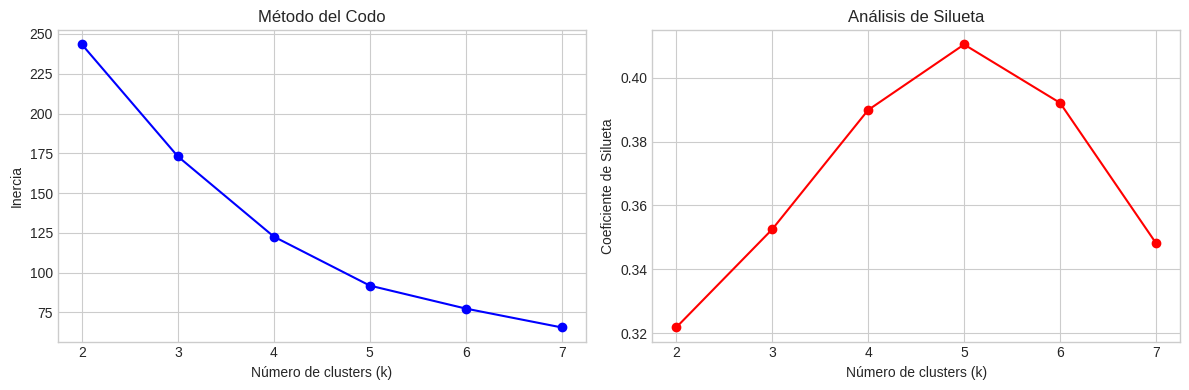

Coeficiente de silueta por k: {2: '0.322', 3: '0.353', 4: '0.390', 5: '0.410', 6: '0.392', 7: '0.348'}


In [15]:
# Variables para clustering (proporciones sectoriales)
df['propEnergia'] = df['emisionesEnergia'] / df['emisionesTotales'].replace(0, np.nan)
df['propAgricultura'] = df['emisionesAgricultura'] / df['emisionesTotales'].replace(0, np.nan)
df['propLULUCF'] = df['emisionesDeforestacion'] / df['emisionesTotales'].replace(0, np.nan)
df['propResiduos'] = df['emisionesResiduos'] / df['emisionesTotales'].replace(0, np.nan)

# Rellenar NaN con 0
cols_prop = ['propEnergia', 'propAgricultura', 'propLULUCF', 'propResiduos']
df[cols_prop] = df[cols_prop].fillna(0)

# Preparar datos para clustering
features_cluster = ['propEnergia', 'propAgricultura', 'propLULUCF', 'balancePerCapita']
X = df[features_cluster].copy()

# Estandarización (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Método del codo y silueta
inertias = []
silhouettes = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Gráfico de selección
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(K_range, inertias, 'bo-')
ax[0].set_xlabel('Número de clusters (k)')
ax[0].set_ylabel('Inercia')
ax[0].set_title('Método del Codo')

ax[1].plot(K_range, silhouettes, 'ro-')
ax[1].set_xlabel('Número de clusters (k)')
ax[1].set_ylabel('Coeficiente de Silueta')
ax[1].set_title('Análisis de Silueta')

plt.tight_layout()
plt.savefig('seleccion_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Coeficiente de silueta por k: {dict(zip(K_range, [f"{s:.3f}" for s in silhouettes]))}')

In [16]:
# Clustering final con k=4 (basado en análisis previo)
# Justificación: k=4 ofrece balance entre interpretabilidad y separación de grupos
K_OPTIMO = 4

kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=RANDOM_STATE, n_init=10)
df['cluster'] = kmeans_final.fit_predict(X_scaled)

# Caracterización de clusters
cluster_profile = df.groupby('cluster').agg({
    'municipio': 'count',
    'balanceCarbono': 'mean',
    'propEnergia': 'mean',
    'propAgricultura': 'mean',
    'capturaBosques': 'mean',
    'totalPoblacion': 'mean'
}).round(2)

cluster_profile.columns = ['n_municipios', 'balance_medio', 'prop_energia', 'prop_agricultura', 'captura_media', 'poblacion_media']

# Etiquetas descriptivas
etiquetas_cluster = {
    cluster_profile['balance_medio'].idxmin(): 'Sumideros Forestales',
    cluster_profile['prop_agricultura'].idxmax(): 'Agrícola-Ganadero',
    cluster_profile['prop_energia'].idxmax(): 'Urbano-Industrial',
}
# Asignar etiqueta restante
for i in range(K_OPTIMO):
    if i not in etiquetas_cluster:
        etiquetas_cluster[i] = 'Mixto-Transición'

df['perfil'] = df['cluster'].map(etiquetas_cluster)

print('Perfil de Clusters:')
print(cluster_profile)

Perfil de Clusters:
         n_municipios  balance_medio  prop_energia  prop_agricultura  \
cluster                                                                
0                  41    -42812.9300        0.0100            0.8000   
1                  21     68653.9300        0.0600            0.2900   
2                  23     16499.5100        0.0200            0.3800   
3                   2     82156.9500        0.6500            0.0600   

         captura_media  poblacion_media  
cluster                                  
0           70338.5800        5435.6800  
1           54908.2000       37754.2400  
2          157581.8300       14294.3500  
3           33446.0400      443906.0000  


## 11. Resultados

### 11.1 Resumen Departamental

In [17]:
# Resumen consolidado
resumen = pd.DataFrame({
    'Módulo': ['Energía', 'IPPU', 'Agricultura', 'Residuos', 'Deforestación', 'TOTAL EMISIONES', 'Captura Bosques', 'BALANCE NETO'],
    'ton CO2eq': [
        df['emisionesEnergia'].sum(),
        df['emisionesIPPU'].sum(),
        df['emisionesAgricultura'].sum(),
        df['emisionesResiduos'].sum(),
        df['emisionesDeforestacion'].sum(),
        df['emisionesTotales'].sum(),
        df['capturaBosques'].sum(),
        df['balanceCarbono'].sum()
    ]
})
resumen['Porcentaje'] = (resumen['ton CO2eq'] / df['emisionesTotales'].sum() * 100).round(2)
resumen.loc[resumen['Módulo'].isin(['Captura Bosques', 'BALANCE NETO']), 'Porcentaje'] = '-'

print('Inventario GEI Santander 2019')
print(resumen.to_string(index=False))

Inventario GEI Santander 2019
         Módulo    ton CO2eq Porcentaje
        Energía  335047.6251     4.2100
           IPPU 1902354.7150    23.9000
    Agricultura 2826744.5310    35.5200
       Residuos   69640.9915     0.8800
  Deforestación 2824645.3989    35.4900
TOTAL EMISIONES 7958433.2614   100.0000
Captura Bosques 7728228.2281          -
   BALANCE NETO  230205.0333          -


In [18]:
# Top 10 municipios emisores
print('Top 10 Municipios Emisores:')
top_emisores = df.nlargest(10, 'balanceCarbono')[['municipio', 'balanceCarbono', 'emisionesPerCapita', 'clasificacion', 'perfil']]
print(top_emisores.to_string(index=False))

Top 10 Municipios Emisores:
       municipio  balanceCarbono  emisionesPerCapita clasificacion            perfil
 BARRANCABERMEJA     551917.5804              3.7948        Emisor  Mixto-Transición
          CURITI     382461.7630             33.0354        Emisor  Mixto-Transición
       CIMITARRA     370443.1617             27.0068        Emisor  Mixto-Transición
  PUERTO WILCHES     252009.3850             11.0636        Emisor  Mixto-Transición
         BOLIVAR     238767.8463             32.6113        Emisor  Mixto-Transición
SABANA DE TORRES     212583.6889             13.3807        Emisor  Mixto-Transición
         ARATOCA     203269.5799             28.1036        Emisor  Mixto-Transición
      LOS SANTOS     147552.6179             12.1012        Emisor  Mixto-Transición
     BUCARAMANGA     128973.2077              0.2868        Emisor Urbano-Industrial
    PUERTO PARRA     108697.1901             33.2121        Emisor  Mixto-Transición


In [19]:
# Top 10 municipios sumideros
print('Top 10 Municipios Sumideros:')
top_sumideros = df.nsmallest(10, 'balanceCarbono')[['municipio', 'balanceCarbono', 'capturaBosques', 'clasificacion', 'perfil']]
print(top_sumideros.to_string(index=False))

Top 10 Municipios Sumideros:
           municipio  balanceCarbono  capturaBosques clasificacion            perfil
            COROMORO    -179277.7683     212526.5382      Sumidero Agrícola-Ganadero
             GAMBITA    -159992.5788     198673.4151      Sumidero Agrícola-Ganadero
               SUCRE    -157239.4372     309543.4266      Sumidero  Mixto-Transición
              ONZAGA    -156737.2371     169425.2495      Sumidero Agrícola-Ganadero
             MOGOTES    -133274.3357     159044.8969      Sumidero  Mixto-Transición
EL CARMEN DE CHUCURI    -130149.8489     347160.1709      Sumidero  Mixto-Transición
              ENCINO    -121364.2180     140212.5948      Sumidero Agrícola-Ganadero
           EL PLAYON    -119840.5543     176671.0269      Sumidero  Mixto-Transición
              SURATA    -102593.9987     118871.4767      Sumidero Agrícola-Ganadero
             CHARALA     -80897.1100     148124.8215      Sumidero Agrícola-Ganadero


### 11.2 Visualizaciones

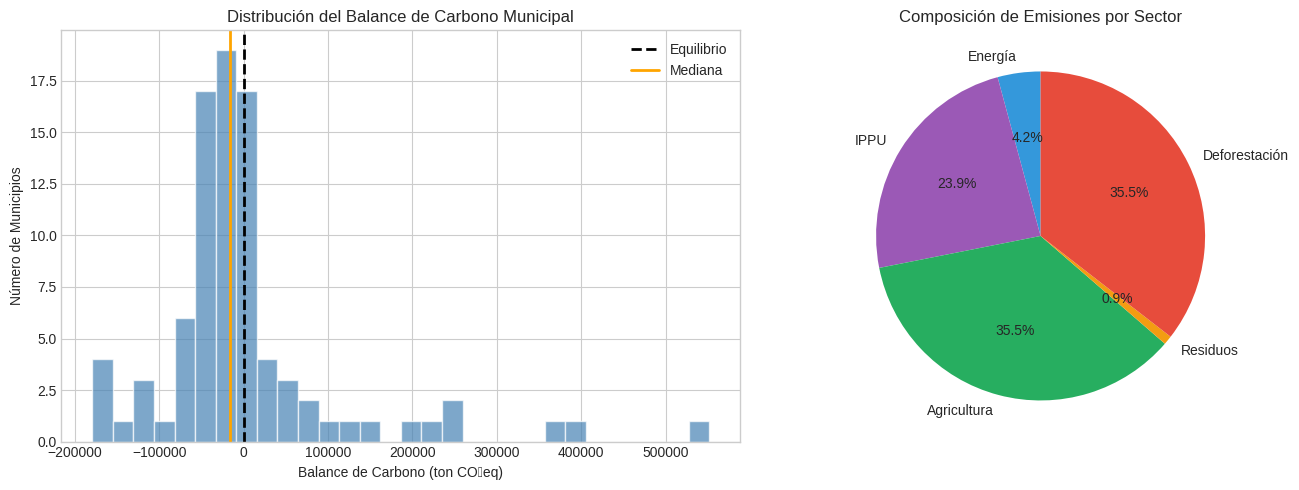

In [20]:
# Distribución del balance de carbono
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de balance
ax1 = axes[0]
colors = ['#2ecc71' if x < 0 else '#e74c3c' for x in df['balanceCarbono']]
ax1.hist(df['balanceCarbono'], bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Equilibrio')
ax1.axvline(x=df['balanceCarbono'].median(), color='orange', linestyle='-', linewidth=2, label='Mediana')
ax1.set_xlabel('Balance de Carbono (ton CO₂eq)')
ax1.set_ylabel('Número de Municipios')
ax1.set_title('Distribución del Balance de Carbono Municipal')
ax1.legend()

# Composición de emisiones por sector
ax2 = axes[1]
sectores = ['Energía', 'IPPU', 'Agricultura', 'Residuos', 'Deforestación']
valores = [
    df['emisionesEnergia'].sum(),
    df['emisionesIPPU'].sum(),
    df['emisionesAgricultura'].sum(),
    df['emisionesResiduos'].sum(),
    df['emisionesDeforestacion'].sum()
]
colores_sector = ['#3498db', '#9b59b6', '#27ae60', '#f39c12', '#e74c3c']
ax2.pie(valores, labels=sectores, autopct='%1.1f%%', colors=colores_sector, startangle=90)
ax2.set_title('Composición de Emisiones por Sector')

plt.tight_layout()
plt.savefig('distribucion_emisiones.png', dpi=150, bbox_inches='tight')
plt.show()

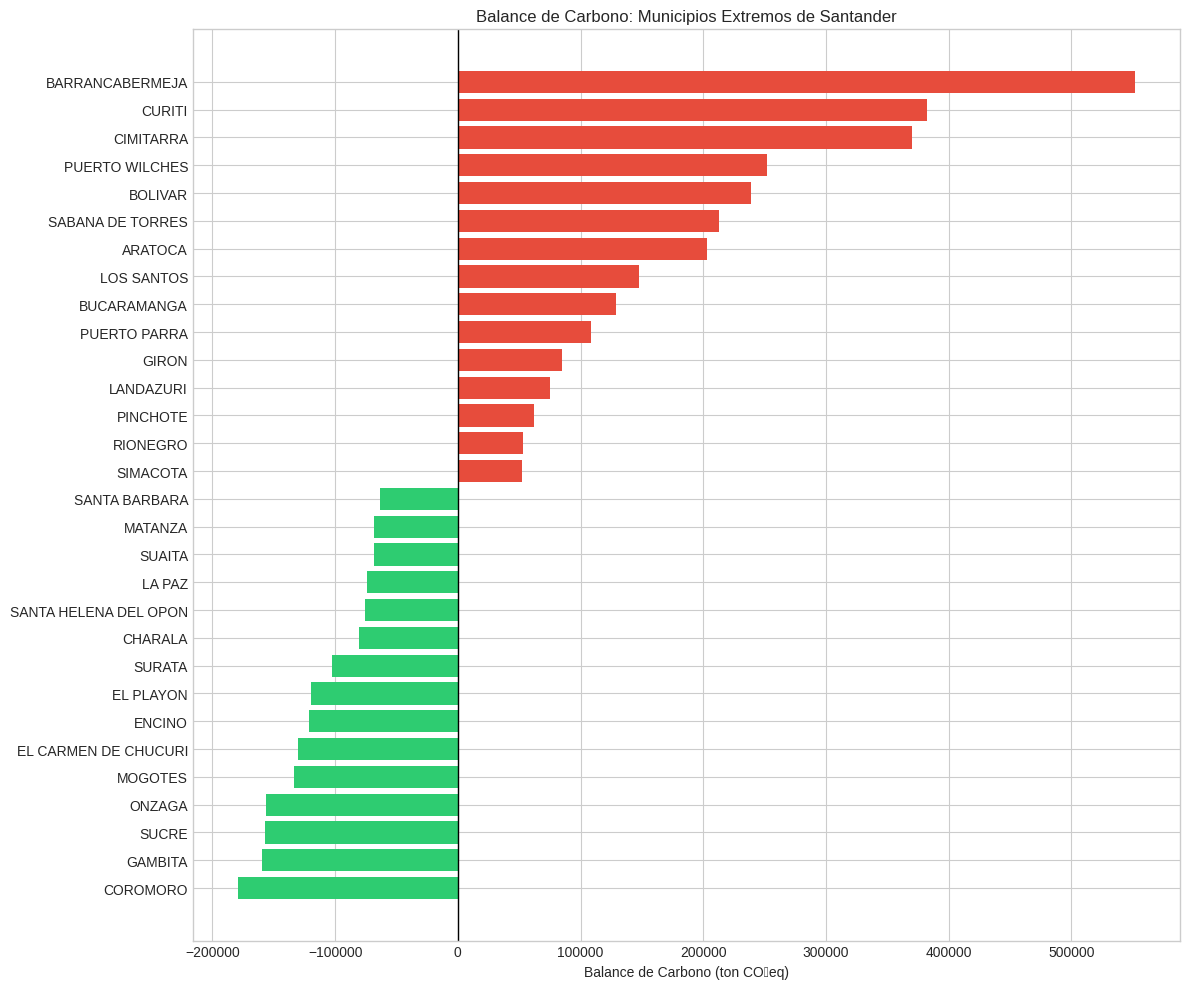

In [21]:
# Balance por municipio (barras horizontales - Top 20 cada extremo)
fig, ax = plt.subplots(figsize=(12, 10))

# Seleccionar top y bottom
top_bottom = pd.concat([
    df.nlargest(15, 'balanceCarbono'),
    df.nsmallest(15, 'balanceCarbono')
]).sort_values('balanceCarbono')

colors = ['#2ecc71' if x < 0 else '#e74c3c' for x in top_bottom['balanceCarbono']]
ax.barh(top_bottom['municipio'], top_bottom['balanceCarbono'], color=colors)
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Balance de Carbono (ton CO₂eq)')
ax.set_title('Balance de Carbono: Municipios Extremos de Santander')

plt.tight_layout()
plt.savefig('balance_municipios.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Mapa Coroplético

Visualización geoespacial del balance de carbono por municipio. Se utiliza una escala divergente donde:
- Verde: Sumidero (balance negativo)
- Amarillo: Equilibrio (balance cercano a cero)
- Rojo: Emisor (balance positivo)

### 12.1 Coordenadas Geográficas

Santander se ubica entre 5°42' y 8°08' de latitud norte, y 72°26' y 74°32' de longitud oeste.

In [22]:
import folium
from branca.colormap import LinearColormap

# Coordenadas geográficas de cabeceras municipales de Santander
# Fuentes: DANE, IGAC, Wikipedia
# Latitud positiva (hemisferio norte), Longitud negativa (oeste de Greenwich)
COORDS_SANTANDER = {
    68013: [6.2500, -73.5167],   # AGUADA
    68020: [6.4333, -73.3167],   # ALBANIA
    68051: [6.6917, -73.0167],   # ARATOCA
    68077: [5.9333, -73.6167],   # BARBOSA
    68079: [6.6333, -73.2167],   # BARICHARA
    68081: [7.0653, -73.8547],   # BARRANCABERMEJA
    68092: [7.0833, -73.2833],   # BETULIA
    68101: [6.0000, -73.3000],   # BOLIVAR
    68001: [7.1254, -73.1198],   # BUCARAMANGA
    68121: [6.5833, -73.2000],   # CABRERA
    68132: [7.3500, -72.9667],   # CALIFORNIA
    68147: [6.5167, -72.6833],   # CAPITANEJO
    68152: [6.6167, -72.6167],   # CARCASI
    68160: [6.7333, -72.9000],   # CEPITA
    68162: [6.3667, -72.6667],   # CERRITO
    68167: [6.2833, -73.1333],   # CHARALA
    68169: [7.2833, -72.9833],   # CHARTA
    68176: [6.3833, -73.5333],   # CHIMA
    68179: [6.5667, -72.7333],   # CHIPATA
    68190: [6.3167, -73.9333],   # CIMITARRA
    68207: [6.3833, -72.7000],   # CONCEPCION
    68209: [6.3500, -73.1167],   # CONFINES
    68211: [6.2833, -73.4333],   # CONTRATACION
    68217: [6.3500, -72.9333],   # COROMORO
    68229: [6.6167, -72.9833],   # CURITI
    68235: [6.7000, -73.5167],   # EL CARMEN DE CHUCURI
    68245: [6.3833, -73.6167],   # EL GUACAMAYO
    68250: [6.0333, -73.9500],   # EL PEÑON
    68255: [7.4833, -73.2000],   # EL PLAYON
    68264: [6.1500, -73.1333],   # ENCINO
    68266: [6.2333, -72.6500],   # ENCISO
    68271: [7.0650, -73.0867],   # FLORIDABLANCA
    68276: [5.8333, -73.9500],   # FLORIAN
    68296: [6.6500, -73.0833],   # GALAN
    68298: [6.0500, -73.3500],   # GAMBITA
    68307: [7.0667, -73.1667],   # GIRON
    68318: [6.8833, -72.8500],   # GUACA
    68320: [6.2500, -72.6500],   # GUADALUPE
    68322: [6.3333, -73.0833],   # GUAPOTA
    68324: [5.9500, -73.6833],   # GUAVATA
    68327: [6.0333, -73.5667],   # GUEPSA
    68344: [6.5500, -73.1333],   # HATO
    68368: [5.9000, -73.7667],   # JESUS MARIA
    68370: [6.7000, -73.0833],   # JORDAN
    68377: [5.8667, -73.9667],   # LA BELLEZA
    68385: [6.2167, -73.8167],   # LANDAZURI
    68397: [6.1833, -73.5833],   # LA PAZ
    68406: [7.1167, -73.2167],   # LEBRIJA
    68418: [6.7833, -73.1000],   # LOS SANTOS
    68425: [6.5000, -72.5833],   # MACARAVITA
    68432: [6.7000, -72.7333],   # MALAGA
    68444: [7.3333, -73.0167],   # MATANZA
    68464: [6.4833, -72.9667],   # MOGOTES
    68468: [6.7500, -72.8167],   # MOLAGAVITA
    68498: [6.4500, -73.1167],   # OCAMONTE
    68500: [6.2667, -73.2833],   # OIBA
    68502: [6.3333, -72.8333],   # ONZAGA
    68522: [6.4833, -73.4833],   # PALMAR
    68524: [6.1500, -73.3167],   # PALMAS DEL SOCORRO
    68533: [6.4333, -73.1833],   # PARAMO
    68547: [6.9833, -73.0500],   # PIEDECUESTA
    68549: [6.5333, -73.1833],   # PINCHOTE
    68572: [5.8833, -73.6833],   # PUENTE NACIONAL
    68573: [7.1833, -73.9000],   # PUERTO PARRA
    68575: [7.3500, -73.9000],   # PUERTO WILCHES
    68615: [7.3833, -73.1500],   # RIONEGRO
    68655: [7.3833, -73.5000],   # SABANA DE TORRES
    68669: [6.3833, -72.8333],   # SAN ANDRES
    68673: [6.0667, -73.2333],   # SAN BENITO
    68679: [6.5500, -73.1333],   # SAN GIL
    68682: [6.4500, -72.8000],   # SAN JOAQUIN
    68684: [6.6167, -72.7000],   # SAN JOSE DE MIRANDA
    68686: [6.3333, -72.6667],   # SAN MIGUEL
    68689: [6.8833, -73.4167],   # SAN VICENTE DE CHUCURI
    68705: [6.0000, -73.5167],   # SANTA BARBARA
    68720: [6.2167, -73.7000],   # SANTA HELENA DEL OPON
    68745: [6.4333, -73.3500],   # SIMACOTA
    68755: [6.4667, -73.2667],   # SOCORRO
    68770: [6.0833, -73.4500],   # SUAITA
    68773: [6.0500, -73.5000],   # SUCRE
    68780: [7.3667, -72.9833],   # SURATA
    68820: [7.2167, -72.9667],   # TONA
    68855: [6.4333, -73.1500],   # VALLE DE SAN JOSE
    68861: [6.0167, -73.6833],   # VELEZ
    68867: [7.3000, -72.8833],   # VETAS
    68872: [6.6667, -73.1833],   # VILLANUEVA
    68895: [6.8167, -73.2667],   # ZAPATOCA
}

# Agregar coordenadas al DataFrame
df['latitud'] = df['codMunicipio'].map(lambda x: COORDS_SANTANDER.get(x, [None, None])[0])
df['longitud'] = df['codMunicipio'].map(lambda x: COORDS_SANTANDER.get(x, [None, None])[1])

print(f'Municipios con coordenadas: {df["latitud"].notna().sum()} de {len(df)}')
print(f'Rango latitud: {df["latitud"].min():.2f}° a {df["latitud"].max():.2f}° N')
print(f'Rango longitud: {df["longitud"].min():.2f}° a {df["longitud"].max():.2f}° W')

Municipios con coordenadas: 87 de 87
Rango latitud: 5.83° a 7.48° N
Rango longitud: -73.97° a -72.58° W


In [23]:
# Crear mapa interactivo con Folium
# Centro aproximado de Santander
centro = [6.65, -73.15]

m = folium.Map(location=centro, zoom_start=8, tiles='cartodbpositron')

# Escala de colores divergente
vmin = df['balanceCarbono'].min()
vmax = df['balanceCarbono'].max()

colormap = LinearColormap(
    colors=['#1a9850', '#91cf60', '#d9ef8b', '#ffffbf', '#fee08b', '#fc8d59', '#d73027'],
    vmin=vmin,
    vmax=vmax,
    caption='Balance de Carbono (ton CO₂eq)'
)

# Agregar marcadores circulares proporcionales al balance
for idx, row in df.iterrows():
    if pd.notna(row['latitud']) and pd.notna(row['longitud']):
        lat, lon = row['latitud'], row['longitud']
        balance = row['balanceCarbono']

        color = colormap(balance)
        radius = min(max(abs(balance) / 15000, 5), 25)

        popup_html = f"""
        <div style='font-family: Arial; font-size: 12px; width: 200px;'>
            <b style='font-size: 14px;'>{row['municipio']}</b><br>
            <hr style='margin: 5px 0;'>
            <b>Balance:</b> {balance:,.0f} ton CO₂eq<br>
            <b>Clasificación:</b> {row['clasificacion']}<br>
            <b>Perfil:</b> {row['perfil']}<br>
            <hr style='margin: 5px 0;'>
            <b>Emisiones:</b> {row['emisionesTotales']:,.0f} ton<br>
            <b>Captura:</b> {row['capturaBosques']:,.0f} ton<br>
            <b>IEC:</b> {row['IEC']:.1f}
        </div>
        """

        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            color='#333',
            weight=1,
            fill=True,
            fillColor=color,
            fillOpacity=0.8,
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=f"{row['municipio']}: {balance:,.0f} ton CO₂eq"
        ).add_to(m)

colormap.add_to(m)

# Título del mapa
title_html = '''
<div style="position: fixed;
            top: 10px; left: 50px; width: 320px;
            background-color: white; padding: 12px;
            border: 2px solid #333; border-radius: 8px;
            z-index: 9999; font-family: Arial;
            box-shadow: 3px 3px 10px rgba(0,0,0,0.3);">
    <h3 style="margin: 0; color: #333;">EcoBalance360 - Santander 2019</h3>
    <p style="margin: 5px 0 0 0; font-size: 12px; color: #666;">Balance de Carbono Municipal</p>
    <div style="margin-top: 8px; font-size: 11px;">
        <span style="color: #1a9850;">●</span> Sumidero (captura > emisiones)<br>
        <span style="color: #d73027;">●</span> Emisor (emisiones > captura)
    </div>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

m.save('mapa_balance_carbono_santander.html')
print('Mapa guardado: mapa_balance_carbono_santander.html')

m

Mapa guardado: mapa_balance_carbono_santander.html


## 13. Exportación de Resultados

In [24]:
# Seleccionar columnas para exportación
columnas_export = [
    'codDepartamento', 'departamento', 'codMunicipio', 'municipio',
    'totalPoblacion',
    # Emisiones por módulo
    'emisionesEnergia', 'emisionesIPPU', 'emisionesAgricultura',
    'emisionesResiduos', 'emisionesDeforestacion',
    # Totales
    'emisionesTotales', 'capturaBosques', 'balanceCarbono',
    # Indicadores
    'emisionesPerCapita', 'balancePerCapita', 'IEC',
    # Clasificaciones
    'clasificacion', 'cluster', 'perfil'
]

df_export = df[columnas_export].copy()

# Guardar CSV
df_export.to_csv('ecobalance360_santander_resultados.csv', index=False, encoding='utf-8-sig')
print('Archivo exportado: ecobalance360_santander_resultados.csv')

# Guardar Excel con múltiples hojas
with pd.ExcelWriter('ecobalance360_santander_resultados.xlsx', engine='openpyxl') as writer:
    df_export.to_excel(writer, sheet_name='Resultados', index=False)
    resumen.to_excel(writer, sheet_name='Resumen_Departamental', index=False)
    cluster_profile.to_excel(writer, sheet_name='Perfiles_Cluster')
    top_emisores.to_excel(writer, sheet_name='Top_Emisores', index=False)
    top_sumideros.to_excel(writer, sheet_name='Top_Sumideros', index=False)

print('Archivo exportado: ecobalance360_santander_resultados.xlsx')

Archivo exportado: ecobalance360_santander_resultados.csv
Archivo exportado: ecobalance360_santander_resultados.xlsx


In [26]:
# Exportar a Excel
nombre_archivo = 'EcoBalance360_Resultados_Santander_2019.xlsx'
df_export.to_excel(nombre_archivo, index=False, sheet_name='Resultados')

# Descargar archivo (en Google Colab)
try:
    from google.colab import files
    files.download(nombre_archivo)
    print(f"\n⬇️ Descargando archivo...")
except:
    print(f"\n💾 Archivo guardado localmente: {nombre_archivo}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


⬇️ Descargando archivo...


## 14. Conclusiones

### 14.1 Hallazgos Principales

1. **Balance departamental**: El análisis permite identificar si Santander es emisor neto o sumidero de carbono en 2019.

2. **Sectores dominantes**: La agricultura (fermentación entérica del ganado) y el uso del suelo (deforestación vs. bosques) son los principales determinantes del balance municipal.

3. **Heterogeneidad municipal**: Existe alta variabilidad entre municipios, con perfiles claramente diferenciados entre zonas urbanas, agrícolas y forestales.

### 14.2 Limitaciones

- Datos de un solo año (2019), sin posibilidad de análisis temporal
- Factores de emisión Tier 1 (IPCC default), no calibrados para condiciones locales
- Algunas variables proxy (VAB para industria) introducen incertidumbre

### 14.3 Recomendaciones

- Priorizar acciones de mitigación en municipios clasificados como "Emisores"
- Proteger y expandir áreas forestales en municipios "Sumidero"
- Implementar programas de ganadería sostenible en municipios con alto perfil agrícola-ganadero

---

## Referencias

- IPCC (2006). 2006 IPCC Guidelines for National Greenhouse Gas Inventories.
- IPCC (2019). 2019 Refinement to the 2006 IPCC Guidelines for National Greenhouse Gas Inventories.
- IDEAM, PNUD, MADS, DNP, CANCILLERÍA (2018). Segundo Informe Bienal de Actualización de Colombia.
- UPME (2019). Factor de Emisión de CO2 del Sistema Interconectado Nacional.